# Kernelized Matrix Factorization on ML-1m

A kernel function allows to transform the product of the factor matrices. Kernels like the s-shaped logistic function allow to impose bounds on the prediction (e.g. one to five stars) while still being differentiable.

The matrix factorization can be expressed as:

$$\hat{r}_{ui} = b_{u,i} + \sum_{f=1}^kw_{u,f}h_{i,f}$$

Like matrix factorization, kernel matrix factorization (KMF) uses two feature matrices that contain the features for users and items, respectively. But the interactions between the feature vector $w_u$ of a user and the feature vector $h_i$ of an item are kernelized:

$$\hat{r}_{ui} = a + c\ \cdot \ K(w_u,h_i)$$

The terms $a$ and $c$ are introduced to allow re-scaling the predictions. For the kernel $K : \mathbb{R}^k × \mathbb{R}^k → \mathbb{R}$ one can use any of the well-known kernels like linear, polynomial, RBF, logistic etc.

It is obvious that normal matrix factorization can be expressed with $a = b_{u,i}$ and $c = 1$ and the linear kernel $K_l$.

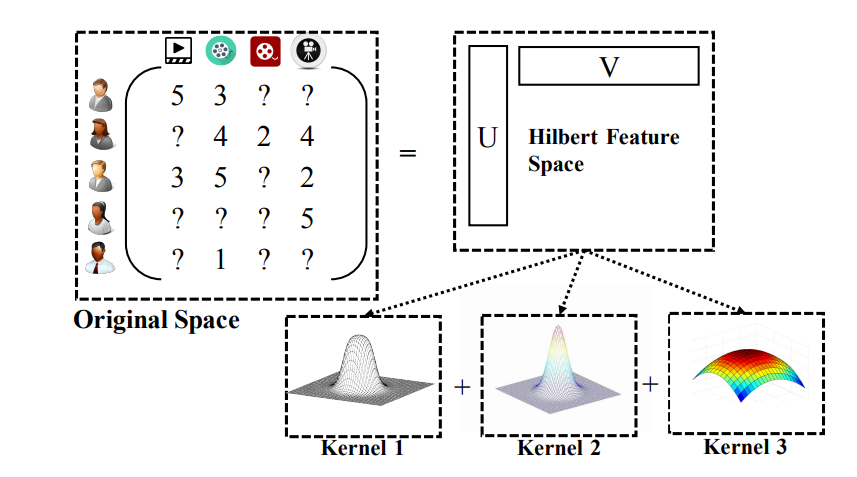

## Setup

In [29]:
from abc import ABCMeta, abstractmethod
from typing import Any, Tuple, Union

import os
import random
import sys

import math
import numpy as np
import pandas as pd
import numba as nb

from sklearn.metrics import mean_squared_error
from sklearn.base import BaseEstimator, RegressorMixin
from sklearn.model_selection import train_test_split

In [30]:
from IPython.core.interactiveshell import InteractiveShell
InteractiveShell.ast_node_interactivity = "all"

pd.options.display.max_rows = 100
    
rand_seed = 2
np.random.seed(rand_seed)
random.seed(rand_seed)

## Utils

In [31]:
def train_update_test_split(
    X: pd.DataFrame, frac_new_users: float
) -> Tuple[pd.DataFrame, pd.Series, pd.DataFrame, pd.Series, pd.DataFrame, pd.Series]:
    """
    Split data into 3 parts (train_initial, train_update, test_update) for testing performance of model update for new users. First, a set of new
    users is set and all ratings corresponding to all other users is assigned to train_initial. Then, for each new user half of their ratings are
    stored in train_update and half are stored in test_update. 
    To use the three sets returned:
        1. Fit your model to train_update set.
        2. Update your model with train_update 
        3. Calculate predictions on test_update and compare with their actual ratings
    Args:
        X (pd.DataFrame): Data frame containing columns user_id, item_id
        frac_new_users (float): Fraction of users to not include in train_initial
    Returns:
        X_train_initial [pd.DataFrame]: Training set user_ids and item_ids for initial model fitting
        y_train_initial [pd.Series]: Corresponding ratings for X_train_initial
        X_train_update [pd.DataFrame]: Training set user_ids and item_ids for model updating. Contains users that are not in train_initial
        y_train_initial [pd.Series]: Corresponding ratings for X_train_update
        X_test_update [pd.DataFrame]: Testing set user_ids and item_ids for model updating. Contains same users as train_update
        y_test_update [pd.Series]: Corresponding ratings for X_test_update
    """
    users = X["user_id"].unique()

    # Users that won't be included in the initial training
    users_update = np.random.choice(
        users, size=round(frac_new_users * len(users)), replace=False
    )

    # Initial training matrix
    train_initial = X.query("user_id not in @users_update").sample(
        frac=1, replace=False
    )

    # Train and test sets for updating model. For each new user split their ratings into two sets, one for update and one for test
    data_update = X.query("user_id in @users_update")
    train_update, test_update = train_test_split(
        data_update, stratify=data_update["user_id"], test_size=0.5
    )

    # Split into X and y
    X_train_initial, y_train_initial = (
        train_initial[["user_id", "item_id"]],
        train_initial["rating"],
    )
    X_train_update, y_train_update = (
        train_update[["user_id", "item_id"]],
        train_update["rating"],
    )
    X_test_update, y_test_update = (
        test_update[["user_id", "item_id"]],
        test_update["rating"],
    )

    return (
        X_train_initial,
        y_train_initial,
        X_train_update,
        y_train_update,
        X_test_update,
        y_test_update,
    )

## Kernels

### Linear

In [32]:
@nb.njit()
def kernel_linear(
    global_mean: float,
    user_bias: float,
    item_bias: float,
    user_feature_vec: np.ndarray,
    item_feature_vec: np.ndarray,
) -> float:
    """
    Calculates result with a linear kernel which is essentially just the dot product
    Args:
        global_mean (float): Global mean
        user_bias (float): User bias
        item_bias (float): Item bias
        user_feature_vec (np.ndarray): Vector of user latent features 
        item_feature_vec (np.ndarray): Vector of item latent features
    Returns:
        [float]: Linear kernel result
    """
    result = (
        global_mean + item_bias + user_bias + np.dot(user_feature_vec, item_feature_vec)
    )
    return result

In [33]:
@nb.njit()
def kernel_linear_sgd_update(
    user_id: int,
    item_id: int,
    rating: float,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    lr: float,
    reg: float,
    update_user_params: bool = True,
    update_item_params: bool = True,
):
    """
    Performs a single update using stochastic gradient descent for a linear kernel given a user and item. 
    Similar to https://github.com/gbolmier/funk-svd and https://github.com/NicolasHug/Surprise we iterate over each factor manually for a given 
    user/item instead of indexing by a row such as user_feature[user] since it has shown to be much faster. We have also tested with representing
    user_features and item_features as 1D arrays but that also is much slower. Using parallel turned on in numba gives much worse performance as well.
    Args:
        user_id (int): User id 
        item_id (int): Item id
        rating (float): Rating for user and item
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User biases vector of shape (n_users, 1)
        item_biases {numpy array} -- Item biases vector of shape (n_items, 1)
        user_features {numpy array} -- Matrix P of user features of shape (n_users, n_factors)
        item_features {numpy array} -- Matrix Q of item features of shape (n_items, n_factors)
        lr (float): Learning rate alpha
        reg {float} -- Regularization parameter lambda for Frobenius norm
        update_user_params {bool} -- Whether to update user parameters or not. Default is True.
        update_item_params {bool} -- Whether to update item parameters or not. Default is True.
    """
    n_factors = user_features.shape[1]
    user_bias = user_biases[user_id]
    item_bias = item_biases[item_id]

    # Compute predicted rating
    rating_pred = (
        global_mean
        + item_bias
        + user_bias
        + np.dot(user_features[user_id, :], item_features[item_id, :])
    )

    # Compute error
    error = rating_pred - rating

    # Update bias parameters
    if update_user_params:
        user_biases[user_id] -= lr * (error + reg * user_bias)

    if update_item_params:
        item_biases[item_id] -= lr * (error + reg * item_bias)

    # Update user and item features
    for f in range(n_factors):
        user_feature_f = user_features[user_id, f]
        item_feature_f = item_features[item_id, f]

        if update_user_params:
            user_features[user_id, f] -= lr * (
                error * item_feature_f + reg * user_feature_f
            )

        if update_item_params:
            item_features[item_id, f] -= lr * (
                error * user_feature_f + reg * item_feature_f
            )

    return

### Sigmoid

In [34]:
@nb.njit()
def sigmoid(x: float) -> float:
    """
    Calculates sigmoid function at x
    Args:
        x (float): Input x
    Returns:
        [float]: Sigmoid at x
    """
    result = 1 / (1 + math.exp(-x))
    return result

In [35]:
@nb.njit()
def kernel_sigmoid(
    global_mean: float,
    user_bias: float,
    item_bias: float,
    user_feature_vec: np.ndarray,
    item_feature_vec: np.ndarray,
    a: float,
    c: float,
):
    """
    Calculates result with sigmoid kernel
    Args:
        global_mean (float): Global mean
        user_bias (float): User bias
        item_bias (float): Item bias
        user_feature_vec (np.ndarray): Vector of user latent features
        item_feature_vec (np.ndarray): Vector of item latent features
        a (float): Rescaling parameter for a + c * K(u, i)
        c (float): Rescaling parameter for a + c * K(u, i)
    Returns:
        [float]: Sigmoid kernel result
    """
    linear_sum = (
        global_mean + user_bias + item_bias + np.dot(user_feature_vec, item_feature_vec)
    )
    sigmoid_result = sigmoid(linear_sum)
    result = a + c * sigmoid_result
    return result

In [36]:
@nb.njit()
def kernel_sigmoid_sgd_update(
    user_id: int,
    item_id: int,
    rating: float,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    lr: float,
    reg: float,
    a: float,
    c: float,
    update_user_params: bool = True,
    update_item_params: bool = True,
):
    """
    Performs a single update using stochastic gradient descent for a sigmoid kernel given a user and item. 
    Args:
        user_id (int): User id 
        item_id (int): Item id
        rating (float): Rating for user and item
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User biases vector of shape (n_users, 1)
        item_biases {numpy array} -- Item biases vector of shape (n_items, 1)
        user_features {numpy array} -- Matrix P of user features of shape (n_users, n_factors)
        item_features {numpy array} -- Matrix Q of item features of shape (n_items, n_factors)
        lr (float): Learning rate alpha
        reg {float} -- Regularization parameter lambda for Frobenius norm
        a (float): Rescaling parameter for a + c * K(u, i)
        c (float): Rescaling parameter for a + c * K(u, i)
        update_user_params {bool} -- Whether to update user parameters or not. Default is True.
        update_item_params {bool} -- Whether to update item parameters or not. Default is True.
    """
    n_factors = user_features.shape[1]
    user_bias = user_biases[user_id]
    item_bias = item_biases[item_id]
    user_feature_vec = user_features[user_id, :]
    item_feature_vec = item_features[item_id, :]

    # Compute predicted rating
    linear_sum = (
        global_mean + user_bias + item_bias + np.dot(user_feature_vec, item_feature_vec)
    )
    sigmoid_result = sigmoid(linear_sum)
    rating_pred = a + c * sigmoid_result

    # Compute error
    error = rating_pred - rating

    # Common term shared between all partial derivatives
    deriv_base = (sigmoid_result ** 2) * math.exp(-linear_sum)

    # Update bias parameters
    if update_user_params:
        opt_deriv = error * deriv_base + reg * user_bias
        user_biases[user_id] -= lr * opt_deriv

    if update_item_params:
        opt_deriv = error * deriv_base + reg * item_bias
        item_biases[item_id] -= lr * opt_deriv

    # Update user and item features
    for i in range(n_factors):
        user_feature_f = user_features[user_id, i]
        item_feature_f = item_features[item_id, i]

        if update_user_params:
            user_feature_deriv = item_feature_f * deriv_base
            opt_deriv = error * user_feature_deriv + reg * user_feature_f
            user_features[user_id, i] -= lr * opt_deriv

        if update_item_params:
            item_feature_deriv = user_feature_f * deriv_base
            opt_deriv = error * item_feature_deriv + reg * item_feature_f
            item_features[item_id, i] -= lr * opt_deriv

    return

### RBF

In [37]:
@nb.njit()
def kernel_rbf(
    user_feature_vec: np.ndarray,
    item_feature_vec: np.ndarray,
    gamma: float,
    a: float,
    c: float,
):
    """
    Calculates result with Radial basis function kernel
    Args:
        user_feature_vec (np.ndarray): Vector of user latent features
        item_feature_vec (np.ndarray): Vector of item latent features
        gamma (float): Kernel coefficient
        a (float): Rescaling parameter for a + c * K(u, i)
        c (float): Rescaling parameter for a + c * K(u, i)
    Returns:
        [float]: RBF kernel result 
    """
    power = -gamma * np.sum(np.square(user_feature_vec - item_feature_vec))
    exp_result = math.exp(power)
    result = a + c * exp_result
    return result

In [38]:
@nb.njit()
def kernel_rbf_sgd_update(
    user_id: int,
    item_id: int,
    rating: float,
    user_features: np.ndarray,
    item_features: np.ndarray,
    lr: float,
    reg: float,
    gamma: float,
    a: float,
    c: float,
    update_user_params: bool = True,
    update_item_params: bool = True,
):
    """
    Performs a single update using stochastic gradient descent for a sigmoid kernel given a user and item. 
    Args:
        user_id (int): User id 
        item_id (int): Item id
        rating (float): Rating for user and item
        user_features {numpy array} -- Matrix P of user features of shape (n_users, n_factors)
        item_features {numpy array} -- Matrix Q of item features of shape (n_items, n_factors)
        lr (float): Learning rate alpha
        reg {float} -- Regularization parameter lambda for Frobenius norm
        gamma (float): Kernel coefficient
        a (float): Rescaling parameter for a + c * K(u, i)
        c (float): Rescaling parameter for a + c * K(u, i)
        update_user_params {bool} -- Whether to update user parameters or not. Default is True.
        update_item_params {bool} -- Whether to update item parameters or not. Default is True.
    """
    n_factors = user_features.shape[1]
    user_feature_vec = user_features[user_id, :]
    item_feature_vec = item_features[item_id, :]

    # Compute predicted rating
    power = -gamma * np.sum(np.square(user_feature_vec - item_feature_vec))
    exp_result = math.exp(power)
    rating_pred = a + c * exp_result

    # Compute error
    error = rating_pred - rating

    # Common term shared between partial derivatives
    deriv_base = 2 * exp_result * gamma

    # Update user and item features params
    for i in range(n_factors):
        user_feature_f = user_features[user_id, i]
        item_feature_f = item_features[item_id, i]

        if update_user_params:
            user_feature_deriv = deriv_base * (item_feature_f - user_feature_f)
            opt_deriv = error * user_feature_deriv + reg * user_feature_f
            user_features[user_id, i] -= lr * opt_deriv

        if update_item_params:
            item_feature_deriv = deriv_base * (user_feature_f - item_feature_f)
            opt_deriv = error * item_feature_deriv + reg * item_feature_f
            item_features[item_id, i] -= lr * opt_deriv

    return

## Models

### Abstract

In [39]:
class RecommenderBase(BaseEstimator, RegressorMixin, metaclass=ABCMeta):
    """
    Abstract base class for all recommender models.
    All subclasses should implement the fit() and predict() methods
    Arguments:
        min_rating {int} -- Smallest rating possible (default: {0})
        max_rating {int} -- Largest rating possible (default: {5})
        verbose {str} -- Verbosity when fitting. Values possible are 0 to not print anything, 1 to print fitting model (default: {1})
    Attributes:
        n_users {int} -- Number of users
        n_items {int} -- Number of items
        global_mean {float} -- Global mean of all ratings
        user_id_map {dict} -- Mapping of user ids to assigned integer ids
        item_id_map {dict} -- Mapping of item ids to assigned integer ids
        known_users {set} -- Set of known user_ids
        known_items {set} -- Set of known item_ids
    """

    @abstractmethod
    def __init__(self, min_rating: float = 0, max_rating: float = 5, verbose: int = 0):
        self.min_rating = min_rating
        self.max_rating = max_rating
        self.verbose = verbose
        return

    @property
    def known_users(self):
        """
        List of known user_ids
        """
        return set(self.user_id_map.keys())

    @property
    def known_items(self):
        """
        List of known item_ids
        """
        return set(self.item_id_map.keys())

    def contains_user(self, user_id: Any) -> bool:
        """
        Checks if model was trained on data containing given user_id
        Args:
            user_id (any): User id
        Returns:
            bool: If user_id is known
        """
        return user_id in self.known_users

    def contains_item(self, item_id: Any) -> bool:
        """
        Checks if model was trained on data containing given item_id
        Args:
            item_id (any): Item id
        Returns:
            bool: If item_id is known
        """
        return item_id in self.known_items

    def _preprocess_data(
        self, X: pd.DataFrame, y: pd.Series = None, type: str = "fit"
    ) -> Union[pd.DataFrame, Tuple[pd.DataFrame, list, list]]:
        """
        Preprocessing steps before doing fit, update or predict
        Arguments:
            X {pd.DataFrame} -- Dataframe containing columns user_id, item_id
            y {pd.Series} -- Series containing rating
            type {str} -- The type of preprocessing to do. Allowed options are ('fit', 'predict', 'update'). Defaults to 'fit'
        Returns:
            X [pd.DataFrame] -- Dataframe with columns user_id, item_id and rating
            known_users [list, 'on update only'] -- List containing already known users in X. Only returned for type update
            new_users [list, 'on update only'] -- List containing new users in X. Only returned for type update
        """
        X = X.loc[:, ["user_id", "item_id"]]

        if type != "predict":
            X["rating"] = y

        if type in ("fit", "update"):
            # Check for duplicate user-item ratings
            if X.duplicated(subset=["user_id", "item_id"]).sum() != 0:
                raise ValueError("Duplicate user-item ratings in matrix")

            # Shuffle rows
            X = X.sample(frac=1, replace=False)

        if type == "fit":
            # Create mapping of user_id and item_id to assigned integer ids
            user_ids = X["user_id"].unique()
            item_ids = X["item_id"].unique()
            self.user_id_map = {user_id: i for (i, user_id) in enumerate(user_ids)}
            self.item_id_map = {item_id: i for (i, item_id) in enumerate(item_ids)}
            self.n_users = len(user_ids)
            self.n_items = len(item_ids)

        elif type == "update":
            # Keep only item ratings for which the item is already known
            items = self.item_id_map.keys()
            X = X.query("item_id in @items").copy()

            # Add information on new users
            new_users, known_users = [], []
            users = X["user_id"].unique()
            new_user_id = max(self.user_id_map.values()) + 1

            for user in users:
                if user in self.user_id_map.keys():
                    known_users.append(user)
                    continue

                # Add to user id mapping
                new_users.append(user)
                self.user_id_map[user] = new_user_id
                new_user_id += 1

        # Remap user id and item id to assigned integer ids
        X.loc[:, "user_id"] = X["user_id"].map(self.user_id_map)
        X.loc[:, "item_id"] = X["item_id"].map(self.item_id_map)

        if type == "predict":
            # Replace missing mappings with -1
            X.fillna(-1, inplace=True)

        if type == "update":
            return X, known_users, new_users
        else:
            return X

    @abstractmethod
    def fit(self, X: pd.DataFrame, y: pd.Series):
        """
        Fit model to given data
        Args:
            X {pandas DataFrame} -- Dataframe containing columns user_id, item_id
            y {pandas DataFrame} -- Series containing rating
        """
        return self

    @abstractmethod
    def predict(self, X: pd.DataFrame, bound_ratings: bool = True) -> list:
        """
        Predict ratings for given users and items
        Args:
            X (pd.DataFrame): Dataframe containing columns user_id and item_id
            bound_ratings (bool): Whether to bound ratings in range [min_rating, max_rating] (default: True)
        Returns:
            list: List containing rating predictions of all user, items in same order as input X
        """
        return []

    def recommend(
        self,
        user: Any,
        amount: int = 10,
        items_known: list = None,
        include_user: bool = True,
        bound_ratings: bool = True,
    ) -> pd.DataFrame:
        """
        Returns a DataFrame of recommendations of items for a given user sorted from highest to lowest.
        Args:
            user (any): User_id to get recommendations for (not assigned user_id from self.user_id_map)
            items_known (list, optional): List of items already known by user and to not be considered in recommendations. Defaults to None.
            include_user (bool, optional): Whether to include the user_id in the output DataFrame or not. Defaults to True.
            bound_ratings (bool): Whether to bound ratings in range [min_rating, max_rating] (default: True)
        Returns:
            pd.DataFrame: Recommendations DataFrame for user with columns user_id (optional), item_id, rating sorted from highest to lowest rating 
        """
        items = list(self.item_id_map.keys())

        # If items_known is provided then filter by items that the user does not know
        if items_known is not None:
            items_known = list(items_known)
            items = [item for item in items if item not in items_known]

        # Get rating predictions for given user and all unknown items
        items_recommend = pd.DataFrame({"user_id": user, "item_id": items})
        items_recommend["rating_pred"] = self.predict(
            X=items_recommend, bound_ratings=False
        )

        # Sort and keep top n items
        items_recommend.sort_values(by="rating_pred", ascending=False, inplace=True)
        items_recommend = items_recommend.head(amount)

        # Bound ratings
        if bound_ratings:
            items_recommend["rating_pred"] = items_recommend["rating_pred"].clip(
                lower=self.min_rating, upper=self.max_rating
            )

        if not include_user:
            items_recommend.drop(["user_id"], axis="columns", inplace=True)

        return items_recommend

### Baseline

In [40]:
class BaselineModel(RecommenderBase):
    """
    Simple model which models the user item rating as r_{ui} = \mu + ubias_u + ibias_i which is sum of a global mean and the corresponding
    user and item biases. The global mean \mu is estimated as the mean of all ratings. The other parameters to be estimated ubias and ibias 
    are vectors of length n_users and n_items respectively. These two vectors are estimated using stochastic gradient descent on the RMSE 
    with regularization.
    NOTE: Recommend method with this model will simply recommend the most popular items for every user. This model should mainly be used
          for estimating the explicit rating for a given user and item 
    Arguments:
        method: {str} -- Method to estimate parameters. Can be one of 'sgd' or 'als' (default: {'sgd'})
        n_epochs {int} -- Number of epochs to train for (default: {100})
        reg {float} -- Lambda parameter for L2 regularization (default: {1})
        lr {float} -- Learning rate for gradient optimization step (default: {0.01})
        min_rating {int} -- Smallest rating possible (default: {0})
        max_rating {int} -- Largest rating possible (default: {5})
        verbose {str} -- Verbosity when fitting. 0 to not print anything, 1 to print fitting model (default: {1})
    Attributes:
        n_users {int} -- Number of users
        n_items {int} -- Number of items
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User bias vector of shape (n_users, 1)
        item_biases {numpy array} -- Item bias vector of shape (n_items, i)
        user_id_map {dict} -- Mapping of user ids to assigned integer ids
        item_id_map {dict} -- Mapping of item ids to assigned integer ids
        train_rmse {list} -- Training rmse values
        predictions_possible {list} -- Boolean vector of whether both user and item were known for prediction. Only available after calling predict
    """

    def __init__(
        self,
        method: str = "sgd",
        n_epochs: int = 100,
        reg: float = 1,
        lr: float = 0.01,
        min_rating: int = 0,
        max_rating: int = 5,
        verbose=1,
    ):
        # Check inputs
        if method not in ("sgd", "als"):
            raise ValueError('Method param must be either "sgd" or "als"')

        super().__init__(min_rating=min_rating, max_rating=max_rating, verbose=verbose)

        self.method = method
        self.n_epochs = n_epochs
        self.reg = reg
        self.lr = lr
        return

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """ 
        Fits simple mean and bias model to given user item ratings
        Arguments:
            X {pandas DataFrame} -- Dataframe containing columns user_id, item_id
            y {pandas Series} -- Series containing rating
        """
        X = self._preprocess_data(X=X, y=y, type="fit")
        self.global_mean = X["rating"].mean()

        # Initialize parameters
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)

        # Run parameter estimation
        if self.method == "sgd":
            self.user_biases, self.item_biases, self.train_rmse = _sgd(
                X=X.to_numpy(),
                global_mean=self.global_mean,
                user_biases=self.user_biases,
                item_biases=self.item_biases,
                n_epochs=self.n_epochs,
                lr=self.lr,
                reg=self.reg,
                verbose=self.verbose,
            )

        elif self.method == "als":
            self.user_biases, self.item_biases, self.train_rmse = _als(
                X=X.to_numpy(),
                global_mean=self.global_mean,
                user_biases=self.user_biases,
                item_biases=self.item_biases,
                n_epochs=self.n_epochs,
                reg=self.reg,
                verbose=self.verbose,
            )

        return self

    def predict(self, X: pd.DataFrame, bound_ratings: bool = True) -> list:
        """
        Predict ratings for given users and items
        Arguments:
            X {pd.DataFrame} -- Dataframe containing columns user_id and item_id
            bound_ratings (bool): Whether to bound ratings in range [min_rating, max_rating] (default: True)
        Returns:
            predictions [list] -- List containing rating predictions of all user, items in same order as input X
        """
        # If empty return empty list
        if X.shape[0] == 0:
            return []

        X = self._preprocess_data(X=X, type="predict")

        # Get predictions
        predictions, predictions_possible = _predict(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            bound_ratings=bound_ratings,
        )

        self.predictions_possible = predictions_possible

        return predictions

    def update_users(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        lr: float = 0.01,
        n_epochs: int = 20,
        verbose: int = 0,
    ):
        """
        Update user biases vector with new/updated user-item ratings information using SGD. Only the user parameters corresponding for the
        new/updated users will be updated and item parameters will be left alone. 
        
        Note: If updating old users then pass all user-item ratings for old users and not just modified ratings
        Args:
            X (pd.DataFrame): Dataframe containing columns user_id, item_id 
            y (pd.Series): Series containing rating
            lr (float, optional): Learning rate alpha for gradient optimization step
            n_epochs (int, optional): Number of epochs to run SGD. Defaults to 20.
            verbose (int, optional): Verbosity when updating, 0 for nothing and 1 for training messages. Defaults to 0.
        """
        X, known_users, new_users = self._preprocess_data(X=X, y=y, type="update")

        # Re-initialize user bias for old users
        for user in known_users:
            user_index = self.user_id_map[user]
            self.user_biases[user_index] = 0

        # Add user bias param for new users
        self.user_biases = np.append(self.user_biases, np.zeros(len(new_users)))

        # Estimate new bias parameter
        self.user_biases, _, self.train_rmse = _sgd(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            n_epochs=n_epochs,
            lr=lr,
            reg=self.reg,
            verbose=verbose,
            update_item_params=False,
        )

        return


@nb.njit()
def _calculate_rmse(
    X: np.ndarray, global_mean: float, user_biases: np.ndarray, item_biases: np.ndarray
):
    """
    Calculates root mean squared error for given data and model parameters
    Args:
        X (np.ndarray): Matrix with columns user, item and rating
        global_mean (float): Global mean rating
        user_biases (np.ndarray): User biases vector of shape (n_users, 1)
        item_biases (np.ndarray): Item biases vector of shape (n_items, 1)
    Returns:
        rmse [float]: Root mean squared error
    """
    n_ratings = X.shape[0]
    errors = np.zeros(n_ratings)

    # Iterate through all user-item ratings
    for i in range(n_ratings):
        user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]

        # Calculate prediction and error
        pred = global_mean + user_biases[user_id] + item_biases[item_id]
        errors[i] = rating - pred

    rmse = np.sqrt(np.square(errors).mean())

    return rmse


@nb.njit()
def _sgd(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    n_epochs: int,
    lr: float,
    reg: float,
    verbose: int,
    update_user_params: bool = True,
    update_item_params: bool = True,
) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Performs Stochastic Gradient Descent to estimate the user_biases and item_biases
    Arguments:
        X {numpy array} -- User-item rating matrix
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User biases vector of shape (n_users, 1)
        item_biases {numpy array} -- Item biases vector of shape (n_items, 1)
        n_epochs {int} -- Number of epochs to run
        lr {float} -- Learning rate alpha
        reg {float} -- Regularization parameter lambda for Frobenius norm
        verbose {int} -- Verbosity when fitting. 0 for nothing and 1 for printing epochs
        update_user_params {bool} -- Whether to update user bias parameters or not. Default is True.
        update_item_params {bool} -- Whether to update item bias parameters or not. Default is True.
    Returns:
        user_biases [np.ndarray] -- Updated user_biases vector
        item_biases [np.ndarray] -- Updated item_bases vector
        train_rmse -- Training rmse values
    """
    train_rmse = []

    for epoch in range(n_epochs):
        # Shuffle data before each epoch
        np.random.shuffle(X)

        # Iterate through all user-item ratings
        for i in range(X.shape[0]):
            user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]

            # Compute error
            rating_pred = global_mean + user_biases[user_id] + item_biases[item_id]
            error = rating - rating_pred

            # Update parameters
            if update_user_params:
                user_biases[user_id] += lr * (error - reg * user_biases[user_id])
            if update_item_params:
                item_biases[item_id] += lr * (error - reg * item_biases[item_id])

        # Calculate error and print
        rmse = _calculate_rmse(
            X=X,
            global_mean=global_mean,
            user_biases=user_biases,
            item_biases=item_biases,
        )
        train_rmse.append(rmse)

        if verbose == 1:
            print("Epoch ", epoch + 1, "/", n_epochs, " -  train_rmse:", rmse)

    return user_biases, item_biases, train_rmse


@nb.njit()
def _als(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    n_epochs: int,
    reg: float,
    verbose: int,
) -> Tuple[np.ndarray, np.ndarray, list]:
    """
    Performs Alternating Least Squares to estimate the user_biases and item_biases. For every epoch, the item biases are held constant while
    solving directly for the user biases parameters using a closed form equation. Then the user biases parameters is held constant and the same
    is done for the item biases. This can be derived easily and is given in the lecture here https://www.youtube.com/watch?v=gCaOa3W9kM0&t=32m55s
    which is also similar to the implementation in Surprise.
    Arguments:
        X {numpy array} -- User-item rating matrix
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User biases vector of shape (n_users, 1)
        item_biases {numpy array} -- Item biases vector of shape (n_items, 1)
        n_epochs {int} -- Number of epochs to run
        reg {float} -- Regularization parameter lambda for Frobenius norm
        verbose {int} -- Verbosity when fitting. 0 for nothing and 1 for printing epochs
    Returns:
        user_biases [np.ndarray] -- Updated user_biases vector
        item_biases [np.ndarray] -- Updated item_bases vector
        train_rmse -- Training rmse values
    """
    n_users = user_biases.shape[0]
    n_items = item_biases.shape[0]
    train_rmse = []

    # Get counts of all users and items
    user_counts = np.zeros(n_users)
    item_counts = np.zeros(n_items)
    for i in range(X.shape[0]):
        user_id, item_id = int(X[i, 0]), int(X[i, 1])
        user_counts[user_id] += 1
        item_counts[item_id] += 1

    # For each epoch optimize User biases, and then Item biases
    for epoch in range(n_epochs):

        # Update user bias parameters
        user_biases = np.zeros(n_users)

        # Iterate through all user-item ratings
        for i in range(X.shape[0]):
            user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]
            user_biases[user_id] += rating - global_mean - item_biases[item_id]

        # Set user bias estimation
        user_biases = user_biases / (reg + user_counts)

        # Update item bias parameters
        item_biases = np.zeros(n_items)

        # Iterate through all user-item ratings
        for i in range(X.shape[0]):
            user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]
            item_biases[item_id] += rating - global_mean - user_biases[user_id]

        # Set item bias estimation
        item_biases = item_biases / (reg + item_counts)

        # Calculate error and print
        rmse = _calculate_rmse(
            X=X,
            global_mean=global_mean,
            user_biases=user_biases,
            item_biases=item_biases,
        )
        train_rmse.append(rmse)

        if verbose == 1:
            print("Epoch ", epoch + 1, "/", n_epochs, " -  train_rmse:", rmse)

    return user_biases, item_biases, train_rmse


@nb.njit()
def _predict(
    X: np.ndarray,
    global_mean: float,
    min_rating: int,
    max_rating: int,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    bound_ratings: bool,
) -> Tuple[list, list]:
    """
    Calculate predicted ratings for each user-item pair.
    Arguments:
        X {np.ndarray} -- Matrix with columns representing (user_id, item_id)
        global_mean {float} -- Global mean of all ratings
        min_rating {int} -- Lowest rating possible
        max_rating {int} -- Highest rating possible
        user_biases {np.ndarray} -- User biases vector of length n_users
        item_biases {np.ndarray} -- Item biases vector of length n_items
        bound_ratings {boolean} -- Whether to bound predictions in between range [min_rating, max_rating]
    Returns:
        predictions [np.ndarray] -- Vector containing rating predictions of all user, items in same order as input X
        predictions_possible [np.ndarray] -- Vector of whether both given user and item were contained in the data that the model was fitted on
    """

    predictions = []
    predictions_possible = []

    for i in range(X.shape[0]):
        user_id, item_id = int(X[i, 0]), int(X[i, 1])
        user_known = user_id != -1
        item_known = item_id != -1

        rating_pred = global_mean

        if user_known:
            rating_pred += user_biases[user_id]
        if item_known:
            rating_pred += item_biases[item_id]

        # Bound ratings to min and max rating range
        if bound_ratings:
            if rating_pred > max_rating:
                rating_pred = max_rating
            elif rating_pred < min_rating:
                rating_pred = min_rating

        predictions.append(rating_pred)
        predictions_possible.append(user_known and item_known)

    return predictions, predictions_possible

### Kernel Matrix Factorization

In [41]:
class KernelMF(RecommenderBase):
    """ 
    Kernel Matrix Factorization. Finds the thin matrices P and Q such that P * Q^T give a good low rank approximation to the user-item 
    ratings matrix A based on RMSE. This is different from SVD despite the name as unlike SVD there is no constraint for matrices P and Q to have mutually
    orthogonal columns. 
    Arguments:
        n_factors {int} -- The number of latent factors in matrices P and Q (default: {100})
        n_epochs {int} -- Number of epochs to train for (default: {100})
        kernel {str} -- Kernel function to use between user and item features. Options are 'linear', 'logistic' or 'rbf'. (default: {'linear'})
        gamma {str or float} -- Kernel coefficient for 'rbf'. Ignored by other kernels. If 'auto' is used then will be set to 1/n_factors. (default: 'auto')
        reg {float} -- Regularization parameter lambda for Tikhonov regularization (default: {0.01})
        lr {float} -- Learning rate alpha for gradient optimization step (default: {0.01})
        init_mean {float} -- Mean of normal distribution to use for initializing parameters (default: {0})
        init_sd {float} -- Standard deviation of normal distribution to use for initializing parameters (default: {0.1})
        min_rating {int} -- Smallest rating possible (default: {0})
        max_rating {int} -- Largest rating possible (default: {5})
        verbose {str} -- Verbosity when fitting. Values possible are 0 to not print anything, 1 to print fitting model (default: {1})
    Attributes:
        n_users {int} -- Number of users
        n_items {int} -- Number of items
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User bias vector of shape (n_users, 1)
        item_biases {numpy array} -- Item bias vector of shape (n_items, i)
        user_features {numpy array} -- Decomposed P matrix of user features of shape (n_users, n_factors)
        item_features {numpy array} -- Decomposed Q matrix of item features of shape (n_items, n_factors)
        user_id_map {dict} -- Mapping of user ids to assigned integer ids
        item_id_map {dict} -- Mapping of item ids to assigned integer ids
        train_rmse -- Training rmse values
        predictions_possible {list} -- Boolean vector of whether both user and item were known for prediction. Only available after calling predict
    """

    def __init__(
        self,
        n_factors: int = 100,
        n_epochs: int = 100,
        kernel: str = "linear",
        gamma: Union[str, float] = "auto",
        reg: float = 1,
        lr: float = 0.01,
        init_mean: float = 0,
        init_sd: float = 0.1,
        min_rating: int = 0,
        max_rating: int = 5,
        verbose: int = 1,
    ):
        if kernel not in ("linear", "sigmoid", "rbf"):
            raise ValueError("Kernel must be one of linear, sigmoid, or rbf")

        super().__init__(min_rating=min_rating, max_rating=max_rating, verbose=verbose)

        self.n_factors = n_factors
        self.n_epochs = n_epochs
        self.kernel = kernel
        self.gamma = 1 / n_factors if gamma == "auto" else gamma
        self.reg = reg
        self.lr = lr
        self.init_mean = init_mean
        self.init_sd = init_sd
        return

    def fit(self, X: pd.DataFrame, y: pd.Series):
        """ 
        Decompose user-item rating matrix into thin matrices P and Q along with user and item bias vectors
        Arguments:
            X {pandas DataFrame} -- Dataframe containing columns user_id, item_id 
            y {pandas Series} -- Series containing ratings
        """
        X = self._preprocess_data(X=X, y=y, type="fit")
        self.global_mean = X["rating"].mean()

        # Initialize vector bias parameters
        self.user_biases = np.zeros(self.n_users)
        self.item_biases = np.zeros(self.n_items)

        # Initialize latent factor parameters of matrices P and Q
        self.user_features = np.random.normal(
            self.init_mean, self.init_sd, (self.n_users, self.n_factors)
        )
        self.item_features = np.random.normal(
            self.init_mean, self.init_sd, (self.n_items, self.n_factors)
        )

        # Perform stochastic gradient descent
        (
            self.user_features,
            self.item_features,
            self.user_biases,
            self.item_biases,
            self.train_rmse,
        ) = _sgd(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            user_features=self.user_features,
            item_features=self.item_features,
            n_epochs=self.n_epochs,
            kernel=self.kernel,
            gamma=self.gamma,
            lr=self.lr,
            reg=self.reg,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            verbose=self.verbose,
        )

        return self

    def predict(self, X: pd.DataFrame, bound_ratings: bool = True) -> list:
        """
        Predict ratings for given users and items
        Arguments:
            X {pd.DataFrame} -- Dataframe containing columns user_id and item_id
            bound_ratings (bool): Whether to bound ratings in range [min_rating, max_rating] (default: True)
        Returns:
            predictions [list] -- List containing rating predictions of all user, items in same order as input X
        """
        # If empty return empty list
        if X.shape[0] == 0:
            return []

        X = self._preprocess_data(X=X, type="predict")

        # Get predictions
        predictions, predictions_possible = _predict(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            user_features=self.user_features,
            item_features=self.item_features,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            kernel=self.kernel,
            gamma=self.gamma,
            bound_ratings=bound_ratings,
        )

        self.predictions_possible = predictions_possible
        return predictions

    def update_users(
        self,
        X: pd.DataFrame,
        y: pd.Series,
        lr: float = 0.01,
        n_epochs: int = 20,
        verbose: int = 0,
    ):
        """
        Update P user features matrix with new/updated user-item ratings information using SGD. Only the user parameters corresponding for the
        new/updated users will be updated and item parameters will be left alone.
        Note: If updating old users then pass all user-item ratings for old users and not just modified ratings
        Args:
            X (pd.DataFrame): Dataframe containing columns user_id, item_id 
            y (pd.DataFrame): Series containing ratings
            lr (float, optional): Learning rate alpha for gradient optimization step
            n_epochs (int, optional): Number of epochs to run SGD. Defaults to 20.
            verbose (int, optional): Verbosity when updating, 0 for nothing and 1 for training messages. Defaults to 0.
        """
        X, known_users, new_users = self._preprocess_data(X=X, y=y, type="update")
        n_new_users = len(new_users)

        # Re-initialize params for old users
        for user in known_users:
            user_index = self.user_id_map[user]

            # Initialize bias
            self.user_biases[user_index] = 0

            # Initialize latent factors vector
            self.user_features[user_index, :] = np.random.normal(
                self.init_mean, self.init_sd, (1, self.n_factors)
            )

        # Add bias parameters for new users
        self.user_biases = np.append(self.user_biases, np.zeros(n_new_users))

        # Add latent factor parameters for new users by adding rows to P matrix
        new_user_features = np.random.normal(
            self.init_mean, self.init_sd, (n_new_users, self.n_factors)
        )
        self.user_features = np.concatenate(
            (self.user_features, new_user_features), axis=0
        )

        # Estimate new parameters
        (
            self.user_features,
            self.item_features,
            self.user_biases,
            self.item_biases,
            self.train_rmse,
        ) = _sgd(
            X=X.to_numpy(),
            global_mean=self.global_mean,
            user_biases=self.user_biases,
            item_biases=self.item_biases,
            user_features=self.user_features,
            item_features=self.item_features,
            n_epochs=n_epochs,
            kernel=self.kernel,
            gamma=self.gamma,
            lr=lr,
            reg=self.reg,
            min_rating=self.min_rating,
            max_rating=self.max_rating,
            verbose=verbose,
            update_item_params=False,
        )

        return

In [42]:
@nb.njit()
def _calculate_rmse(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    min_rating: float,
    max_rating: float,
    kernel: str,
    gamma: float,
):
    """
    Calculates root mean squared error for given data and model parameters
    Args:
        X (np.ndarray): Matrix with columns user, item and rating
        global_mean (float): Global mean rating
        user_biases (np.ndarray): User biases vector of shape (n_users, 1)
        item_biases (np.ndarray): Item biases vector of shape (n_items, 1)
        user_features (np.ndarray): User features matrix P of size (n_users, n_factors)
        item_features (np.ndarray): Item features matrix Q of size (n_items, n_factors)
        min_rating (float): Minimum possible rating
        max_rating (float): Maximum possible rating
        kernel (str): Kernel type. Possible options are "linear", "sigmoid" or "rbf" kernel
        gamma (float): Kernel coefficient only for "rbf" kernel
    Returns:
        rmse [float]: Root mean squared error
    """
    n_ratings = X.shape[0]
    errors = np.zeros(n_ratings)

    # Iterate through all user-item ratings and calculate error
    for i in range(n_ratings):
        user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]
        user_bias = user_biases[user_id]
        item_bias = item_biases[item_id]
        user_feature_vec = user_features[user_id, :]
        item_feature_vec = item_features[item_id, :]

        # Calculate predicted rating for given kernel
        if kernel == "linear":
            rating_pred = kernel_linear(
                global_mean=global_mean,
                user_bias=user_bias,
                item_bias=item_bias,
                user_feature_vec=user_feature_vec,
                item_feature_vec=item_feature_vec,
            )

        elif kernel == "sigmoid":
            rating_pred = kernel_sigmoid(
                global_mean=global_mean,
                user_bias=user_bias,
                item_bias=item_bias,
                user_feature_vec=user_feature_vec,
                item_feature_vec=item_feature_vec,
                a=min_rating,
                c=max_rating - min_rating,
            )

        elif kernel == "rbf":
            rating_pred = kernel_rbf(
                user_feature_vec=user_feature_vec,
                item_feature_vec=item_feature_vec,
                gamma=gamma,
                a=min_rating,
                c=max_rating - min_rating,
            )

        # Calculate error
        errors[i] = rating - rating_pred

    rmse = np.sqrt(np.square(errors).mean())

    return rmse

In [43]:
@nb.njit()
def _sgd(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    n_epochs: int,
    kernel: str,
    gamma: float,
    lr: float,
    reg: float,
    min_rating: float,
    max_rating: float,
    verbose: int,
    update_user_params: bool = True,
    update_item_params: bool = True,
) -> Tuple[np.ndarray, np.ndarray, np.ndarray, np.ndarray, list]:
    """
    Performs stochastic gradient descent to estimate parameters.
    Arguments:
        X {numpy array} -- User-item ranking matrix
        global_mean {float} -- Global mean of all ratings
        user_biases {numpy array} -- User biases vector of shape (n_users, 1)
        item_biases {numpy array} -- Item biases vector of shape (n_items, 1)
        user_features {numpy array} -- Start matrix P of user features of shape (n_users, n_factors)
        item_features {numpy array} -- Start matrix Q of item features of shape (n_items, n_factors)
        n_epochs {int} -- Number of epochs to run
        kernel {str} -- Kernel function to use between user and item features. Options are 'linear', 'logistic', and 'rbf'. 
        gamma {float} -- Kernel coefficient for 'rbf'. Ignored by other kernels. 
        lr {float} -- Learning rate alpha
        reg {float} -- Regularization parameter lambda for Frobenius norm
        min_rating {float} -- Minimum possible rating
        max_fating {float} -- Maximum possible rating
        verbose {int} -- Verbosity when fitting. 0 for nothing and 1 for printing epochs
        update_user_params {bool} -- Whether to update user parameters or not. Default is True.
        update_item_params {bool} -- Whether to update item  parameters or not. Default is True.
    Returns:
        user_features [np.ndarray] -- Updated user_features matrix P
        item_features [np.ndarray] -- Updated item_features matrix Q
        user_biases [np.ndarray] -- Updated user_biases vector
        item_biases [np.ndarray] -- Updated item_bases vector
        train_rmse [list] -- Training rmse values
    """
    train_rmse = []

    for epoch in range(n_epochs):
        # Shuffle dataset before each epoch
        np.random.shuffle(X)

        # Iterate through all user-item ratings
        for i in range(X.shape[0]):
            user_id, item_id, rating = int(X[i, 0]), int(X[i, 1]), X[i, 2]

            if kernel == "linear":
                kernel_linear_sgd_update(
                    user_id=user_id,
                    item_id=item_id,
                    rating=rating,
                    global_mean=global_mean,
                    user_biases=user_biases,
                    item_biases=item_biases,
                    user_features=user_features,
                    item_features=item_features,
                    lr=lr,
                    reg=reg,
                    update_user_params=update_user_params,
                    update_item_params=update_item_params,
                )

            elif kernel == "sigmoid":
                kernel_sigmoid_sgd_update(
                    user_id=user_id,
                    item_id=item_id,
                    rating=rating,
                    global_mean=global_mean,
                    user_biases=user_biases,
                    item_biases=item_biases,
                    user_features=user_features,
                    item_features=item_features,
                    lr=lr,
                    reg=reg,
                    a=min_rating,
                    c=max_rating - min_rating,
                    update_user_params=update_user_params,
                    update_item_params=update_item_params,
                )

            elif kernel == "rbf":
                kernel_rbf_sgd_update(
                    user_id=user_id,
                    item_id=item_id,
                    rating=rating,
                    user_features=user_features,
                    item_features=item_features,
                    lr=lr,
                    reg=reg,
                    gamma=gamma,
                    a=min_rating,
                    c=max_rating - min_rating,
                    update_user_params=update_user_params,
                    update_item_params=update_item_params,
                )

        # Calculate error and print
        rmse = _calculate_rmse(
            X=X,
            global_mean=global_mean,
            user_biases=user_biases,
            item_biases=item_biases,
            user_features=user_features,
            item_features=item_features,
            min_rating=min_rating,
            max_rating=max_rating,
            kernel=kernel,
            gamma=gamma,
        )
        train_rmse.append(rmse)

        if verbose == 1:
            print("Epoch ", epoch + 1, "/", n_epochs, " -  train_rmse:", rmse)

    return user_features, item_features, user_biases, item_biases, train_rmse

In [44]:
@nb.njit()
def _predict(
    X: np.ndarray,
    global_mean: float,
    user_biases: np.ndarray,
    item_biases: np.ndarray,
    user_features: np.ndarray,
    item_features: np.ndarray,
    min_rating: int,
    max_rating: int,
    kernel: str,
    gamma: float,
    bound_ratings: bool,
) -> Tuple[list, list]:
    """ 
    Calculate predicted ratings for each user-item pair.
    Arguments:
        X {np.ndarray} -- Matrix with columns representing (user_id, item_id)
        global_mean {float} -- Global mean of all ratings
        user_biases {np.ndarray} -- User biases vector of length n_users
        item_biases {np.ndarray} -- Item biases vector of length n_items
        user_features {np.ndarray} -- User features matrix P of shape (n_users, n_factors)
        item_features {np.ndarray} -- Item features matrix Q of shape (n_items, n_factors)
        min_rating {int} -- Lowest rating possible
        max_rating {int} -- Highest rating possible
        kernel {str} -- Kernel function. Options are 'linear', 'sigmoid', and 'rbf'
        gamma {float} -- Kernel coefficient for 'rbf' only
        bound_ratings (bool): Whether to bound ratings in range [min_rating, max_rating] (default: True)
    Returns:
        predictions [np.ndarray] -- Vector containing rating predictions of all user, items in same order as input X
        predictions_possible [np.ndarray] -- Vector of whether both given user and item were contained in the data that the model was fitted on
    """
    n_factors = user_features.shape[1]
    predictions = []
    predictions_possible = []

    for i in range(X.shape[0]):
        user_id, item_id = int(X[i, 0]), int(X[i, 1])
        user_known = user_id != -1
        item_known = item_id != -1

        # Default values if user or item are not known
        user_bias = user_biases[user_id] if user_known else 0
        item_bias = item_biases[item_id] if item_known else 0
        user_feature_vec = (
            user_features[user_id, :] if user_known else np.zeros(n_factors)
        )
        item_feature_vec = (
            item_features[item_id, :] if item_known else np.zeros(n_factors)
        )

        # Calculate predicted rating given kernel
        if kernel == "linear":
            rating_pred = kernel_linear(
                global_mean=global_mean,
                user_bias=user_bias,
                item_bias=item_bias,
                user_feature_vec=user_feature_vec,
                item_feature_vec=item_feature_vec,
            )

        elif kernel == "sigmoid":
            rating_pred = kernel_sigmoid(
                global_mean=global_mean,
                user_bias=user_bias,
                item_bias=item_bias,
                user_feature_vec=user_feature_vec,
                item_feature_vec=item_feature_vec,
                a=min_rating,
                c=max_rating - min_rating,
            )

        elif kernel == "rbf":
            rating_pred = kernel_rbf(
                user_feature_vec=user_feature_vec,
                item_feature_vec=item_feature_vec,
                gamma=gamma,
                a=min_rating,
                c=max_rating - min_rating,
            )

        # Bound ratings to min and max rating range
        if bound_ratings:
            if rating_pred > max_rating:
                rating_pred = max_rating
            elif rating_pred < min_rating:
                rating_pred = min_rating

        predictions.append(rating_pred)
        predictions_possible.append(user_known and item_known)

    return predictions, predictions_possible

## Data ML-1m

In [45]:
!wget -q --show-progress http://files.grouplens.org/datasets/movielens/ml-1m.zip
!unzip ml-1m.zip

ml-1m.zip.1         100%[===================>]   5.64M  18.4MB/s    in 0.3s    
Archive:  ml-1m.zip
replace ml-1m/movies.dat? [y]es, [n]o, [A]ll, [N]one, [r]ename: N


In [24]:
cols = ['user_id', 'item_id', 'rating', 'timestamp']
movie_data = pd.read_csv('ml-1m/ratings.dat', names = cols, sep = '::', usecols=[0, 1, 2], engine='python')
# movie_data = pd.read_csv('ml-100k/u.data', names = cols, sep = '\t', usecols=[0, 1, 2], engine='python')
movie_data.head(10)

,user_id,item_id,rating
0,1,1193,5
1,1,661,3
2,1,914,3
3,1,3408,4
4,1,2355,5
5,1,1197,3
6,1,1287,5
7,1,2804,5
8,1,594,4
9,1,919,4


In [46]:
X = movie_data[['user_id', 'item_id']]
y = movie_data['rating']

# Prepare data
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=0.2)

# Prepare data for online learning
X_train_initial, y_train_initial, X_train_update, y_train_update, X_test_update, y_test_update = train_update_test_split(movie_data, frac_new_users=0.2)


In [47]:
X_train_initial.shape, y_train_initial.shape, X_train_update.shape, y_train_update.shape, X_test_update.shape, y_test_update.shape

((798307, 2), (798307,), (100951, 2), (100951,), (100951, 2), (100951,))

## Simple model with global mean

In [48]:
global_mean = y_train.mean()
pred = [global_mean for _ in range(y_test.shape[0])]

rmse = mean_squared_error(y_test, pred, squared = False)

print(f'\nTest RMSE: {rmse:4f}')


Test RMSE: 1.117284


## Matrix Factorization - Linear Kernel

### Full data training

In [53]:
%%time 
matrix_fact = KernelMF(n_epochs = 20, n_factors = 100, verbose = 1, lr = 0.001, reg = 0.005)
matrix_fact.fit(X_train, y_train)

pred = matrix_fact.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 1.0131011486029673
Epoch  2 / 20  -  train_rmse: 0.9736795487732433
Epoch  3 / 20  -  train_rmse: 0.9524095013881799
Epoch  4 / 20  -  train_rmse: 0.9387445909724861
Epoch  5 / 20  -  train_rmse: 0.9289583196388383
Epoch  6 / 20  -  train_rmse: 0.9214328298894139
Epoch  7 / 20  -  train_rmse: 0.915341037862705
Epoch  8 / 20  -  train_rmse: 0.9102190628982334
Epoch  9 / 20  -  train_rmse: 0.9057863730502835
Epoch  10 / 20  -  train_rmse: 0.9018540753357193
Epoch  11 / 20  -  train_rmse: 0.898292334148862
Epoch  12 / 20  -  train_rmse: 0.8950170446830942
Epoch  13 / 20  -  train_rmse: 0.8919594523719323
Epoch  14 / 20  -  train_rmse: 0.8890615425998871
Epoch  15 / 20  -  train_rmse: 0.8862865092807949
Epoch  16 / 20  -  train_rmse: 0.8835982429738573
Epoch  17 / 20  -  train_rmse: 0.8809696427693479
Epoch  18 / 20  -  train_rmse: 0.8783815686975167
Epoch  19 / 20  -  train_rmse: 0.8758045779741251
Epoch  20 / 20  -  train_rmse: 0.8732249161101829

Test RMSE:

### Recommend

In [55]:
user = 200
items_known = X_train.query('user_id == @user')['item_id']
matrix_fact.recommend(user=user, items_known=items_known)

,user_id,item_id,rating_pred
49,200,912,4.821835
851,200,745,4.679905
301,200,260,4.676945
441,200,904,4.637362
1612,200,2019,4.620851
1120,200,1212,4.616918
1820,200,1267,4.605954
1347,200,1207,4.604608
99,200,1198,4.598912
1335,200,3030,4.579230


### Updating with new users

In [56]:
matrix_fact = KernelMF(n_epochs = 20, n_factors = 100, verbose = 1, lr = 0.001, reg = 0.005)
matrix_fact.fit(X_train_initial, y_train_initial)

Epoch  1 / 20  -  train_rmse: 1.0057029101886787
Epoch  2 / 20  -  train_rmse: 0.9672849494021611
Epoch  3 / 20  -  train_rmse: 0.9471655099931005
Epoch  4 / 20  -  train_rmse: 0.9343278608798081
Epoch  5 / 20  -  train_rmse: 0.9251420196454406
Epoch  6 / 20  -  train_rmse: 0.9180591631938331
Epoch  7 / 20  -  train_rmse: 0.9123157968080329
Epoch  8 / 20  -  train_rmse: 0.9074664089003092
Epoch  9 / 20  -  train_rmse: 0.9032607033336629
Epoch  10 / 20  -  train_rmse: 0.8995106953390289
Epoch  11 / 20  -  train_rmse: 0.896102493656463
Epoch  12 / 20  -  train_rmse: 0.8929527874119412
Epoch  13 / 20  -  train_rmse: 0.8899892958081905
Epoch  14 / 20  -  train_rmse: 0.8871633107005222
Epoch  15 / 20  -  train_rmse: 0.8844340778966453
Epoch  16 / 20  -  train_rmse: 0.8817656325712866
Epoch  17 / 20  -  train_rmse: 0.8791306016548486
Epoch  18 / 20  -  train_rmse: 0.8765035456844505
Epoch  19 / 20  -  train_rmse: 0.8738643942101336
Epoch  20 / 20  -  train_rmse: 0.8711891353424065


KernelMF(gamma=0.01, init_mean=0, init_sd=0.1, kernel='linear', lr=0.001,
         max_rating=5, min_rating=0, n_epochs=20, n_factors=100, reg=0.005,
         verbose=1)

In [57]:
matrix_fact.update_users(X_train_update, y_train_update, lr=0.001, n_epochs=20, verbose=1)
pred = matrix_fact.predict(X_test_update)
rmse = mean_squared_error(y_test_update, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 0.975909582166629
Epoch  2 / 20  -  train_rmse: 0.959080812196047
Epoch  3 / 20  -  train_rmse: 0.948133564611734
Epoch  4 / 20  -  train_rmse: 0.9403638197164311
Epoch  5 / 20  -  train_rmse: 0.9345120235560737
Epoch  6 / 20  -  train_rmse: 0.9298684007475237
Epoch  7 / 20  -  train_rmse: 0.9260382783895372
Epoch  8 / 20  -  train_rmse: 0.9227785854943145
Epoch  9 / 20  -  train_rmse: 0.9199343827053205
Epoch  10 / 20  -  train_rmse: 0.9173991826401
Epoch  11 / 20  -  train_rmse: 0.9151056772123974
Epoch  12 / 20  -  train_rmse: 0.9129980219958644
Epoch  13 / 20  -  train_rmse: 0.9110404002105831
Epoch  14 / 20  -  train_rmse: 0.9092067235641966
Epoch  15 / 20  -  train_rmse: 0.9074766228087963
Epoch  16 / 20  -  train_rmse: 0.9058307409724526
Epoch  17 / 20  -  train_rmse: 0.9042586832955035
Epoch  18 / 20  -  train_rmse: 0.9027490928843112
Epoch  19 / 20  -  train_rmse: 0.9012950325382446
Epoch  20 / 20  -  train_rmse: 0.8998884725870293

Test RMSE: 0.9

In [58]:
# Get recommendations
user = 200
items_known = X_train_initial.query("user_id == @user")["item_id"]
matrix_fact.recommend(user=user, items_known=items_known)

,user_id,item_id,rating_pred
1224,200,1212,4.698401
967,200,923,4.664610
646,200,3435,4.662763
87,200,318,4.650573
207,200,2019,4.630115
1068,200,908,4.584827
987,200,858,4.575215
1842,200,3134,4.558520
1409,200,1148,4.548372
267,200,904,4.544163


## Matrix Factorization - Other Kernels

### Sigmoid Kernel

In [59]:
%%time 
matrix_fact = KernelMF(n_epochs = 20, n_factors = 100, verbose = 1, lr = 0.01, reg = 0.005, kernel='sigmoid')
matrix_fact.fit(X_train, y_train)

pred = matrix_fact.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 1.6533814745011026
Epoch  2 / 20  -  train_rmse: 1.5339097750004382
Epoch  3 / 20  -  train_rmse: 1.3750357735637435
Epoch  4 / 20  -  train_rmse: 1.2598375283855168
Epoch  5 / 20  -  train_rmse: 1.1821943554638776
Epoch  6 / 20  -  train_rmse: 1.125262915614807
Epoch  7 / 20  -  train_rmse: 1.0816030874553515
Epoch  8 / 20  -  train_rmse: 1.0475367259773625
Epoch  9 / 20  -  train_rmse: 1.0204813724521518
Epoch  10 / 20  -  train_rmse: 0.9986280715886721
Epoch  11 / 20  -  train_rmse: 0.9806689645125596
Epoch  12 / 20  -  train_rmse: 0.9655707959176579
Epoch  13 / 20  -  train_rmse: 0.9526029726811531
Epoch  14 / 20  -  train_rmse: 0.9412931693032693
Epoch  15 / 20  -  train_rmse: 0.9312064214180387
Epoch  16 / 20  -  train_rmse: 0.9220252109543311
Epoch  17 / 20  -  train_rmse: 0.9136075188303109
Epoch  18 / 20  -  train_rmse: 0.905708941750815
Epoch  19 / 20  -  train_rmse: 0.898232635132515
Epoch  20 / 20  -  train_rmse: 0.8911009955365344

Test RMSE: 

### RBF Kernel

In [60]:
%%time 
matrix_fact = KernelMF(n_epochs = 20, n_factors = 100, verbose = 1, lr = 0.5, reg = 0.005, kernel='rbf')
matrix_fact.fit(X_train, y_train)

pred = matrix_fact.predict(X_test)
rmse = mean_squared_error(y_test, pred, squared = False)

print(f'\nTest RMSE: {rmse:.4f}')

Epoch  1 / 20  -  train_rmse: 1.0636570917207124
Epoch  2 / 20  -  train_rmse: 0.9851395907047712
Epoch  3 / 20  -  train_rmse: 0.9489006996158574
Epoch  4 / 20  -  train_rmse: 0.9297552998825539
Epoch  5 / 20  -  train_rmse: 0.9192067544420423
Epoch  6 / 20  -  train_rmse: 0.9144270881347965
Epoch  7 / 20  -  train_rmse: 0.9116770966382195
Epoch  8 / 20  -  train_rmse: 0.9106819948414826
Epoch  9 / 20  -  train_rmse: 0.909811580700564
Epoch  10 / 20  -  train_rmse: 0.9092809320293156
Epoch  11 / 20  -  train_rmse: 0.9086799364228837
Epoch  12 / 20  -  train_rmse: 0.9097652008543395
Epoch  13 / 20  -  train_rmse: 0.9089165464493334
Epoch  14 / 20  -  train_rmse: 0.9082873761282293
Epoch  15 / 20  -  train_rmse: 0.9084235459321134
Epoch  16 / 20  -  train_rmse: 0.9089233921257058
Epoch  17 / 20  -  train_rmse: 0.9095161885319636
Epoch  18 / 20  -  train_rmse: 0.9095021122808937
Epoch  19 / 20  -  train_rmse: 0.9094299427056528
Epoch  20 / 20  -  train_rmse: 0.9094549873196524

Test RMSE

## Hyperparameter Tuning

In [61]:
from sklearn.model_selection import GridSearchCV, ParameterGrid

param_grid = {
    'kernel': ['linear', 'sigmoid', 'rbf'],
    'n_factors': [10, 20, 50],
    'n_epochs': [10, 20, 50],
    'reg': [0, 0.005, 0.1]
}

grid_search = GridSearchCV(KernelMF(verbose=0), scoring = 'neg_root_mean_squared_error', param_grid=param_grid, n_jobs=-1, cv=5, verbose=1)
grid_search.fit(X_train, y_train)

grid_search.best_score_, grid_search.best_params_

Fitting 5 folds for each of 81 candidates, totalling 405 fits


[Parallel(n_jobs=-1)]: Using backend LokyBackend with 2 concurrent workers.
[Parallel(n_jobs=-1)]: Done  46 tasks      | elapsed:  3.5min
[Parallel(n_jobs=-1)]: Done 196 tasks      | elapsed: 28.6min
[Parallel(n_jobs=-1)]: Done 405 out of 405 | elapsed: 86.7min finished


GridSearchCV(cv=5, error_score=nan,
             estimator=KernelMF(gamma=0.01, init_mean=0, init_sd=0.1,
                                kernel='linear', lr=0.01, max_rating=5,
                                min_rating=0, n_epochs=100, n_factors=100,
                                reg=1, verbose=0),
             iid='deprecated', n_jobs=-1,
             param_grid={'kernel': ['linear', 'sigmoid', 'rbf'],
                         'n_epochs': [10, 20, 50], 'n_factors': [10, 20, 50],
                         'reg': [0, 0.005, 0.1]},
             pre_dispatch='2*n_jobs', refit=True, return_train_score=False,
             scoring='neg_root_mean_squared_error', verbose=1)

(-0.8688711942781527,
 {'kernel': 'linear', 'n_epochs': 50, 'n_factors': 50, 'reg': 0.1})